# <center> Data Mining & Machine Learning - Assignment 1
## <center> Rajas Vaidya (MDS202131)
## <center> Rohan Dharmadhikari (MDS202137) <br><br>

In this assignment, we have built three classifiers for the 'Bank Marketing Data Set" from the UCI Machine Learning Repository, viz., <br>
 - Decision Tree
 - Naïve Bayes Classifier
 - Random Forest

Before building any classifier models, we have set aside 30% of the samples, randomly, to be used as the test data for all three classifiers and compare the performance of each classifier on that test data. <br>

The packages used in preparing the data and building the classifiers are - 
 - Scikit-Learn
 - Pandas
 - Matplotlib
 - Numpy
 - Seaborn
 - imblearn 

#### Importing Common Packages across all classifiers

In [16]:
import os
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

#### Defining Directories

In [17]:
# Defining Root, Input, Output Directories
root_dir = "."
bank_data_path = os.path.join(root_dir,"bank-data", "bank-additional-full.csv")

#### Loading data using Pandas

In [18]:
# Loading Bank Dataset
bank_data_df = pd.read_csv(bank_data_path, sep=";")
target_names = bank_data_df.iloc[:,20].unique()
bank_data_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### Data Preparation

We have dropped the column 'duration' from the data. This is due to the fact that we cannot forsee how long each call will last before its made and once we know the duration of the call (when it ends), we already know the result as well. This has also been explained in the description of the data provided by UCI.

<AxesSubplot:xlabel='y', ylabel='count'>

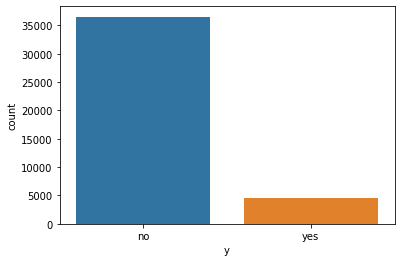

In [19]:
# Dropping Column 'duration'
bank_data_df = bank_data_df.drop(columns=['duration'])

# Checking distribution of target column
sns.countplot(x='y',data=bank_data_df)

Since the data is so skewed, we have set the class_weight parameter in the classifiers to "balanced" to adjust class weights according to their representation in the samples.

##### Getting summary of numerical variables

In [20]:
bank_data_df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


##### Graphs for numerical variables

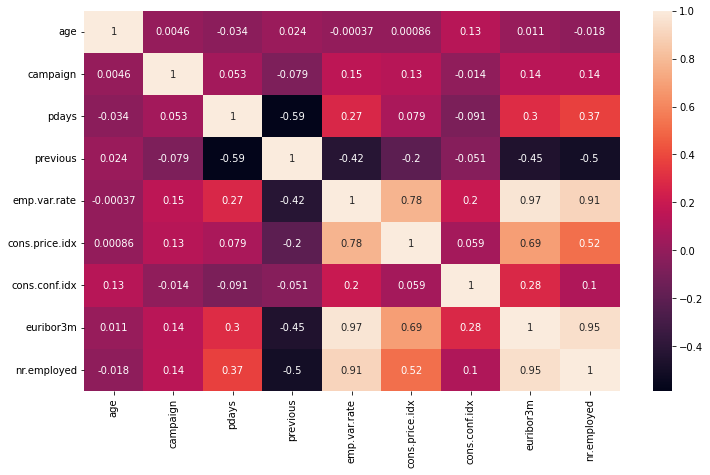

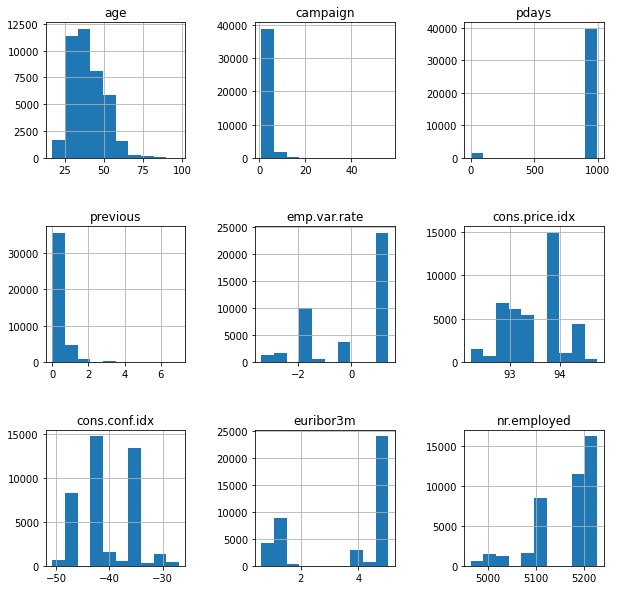

In [21]:
# Correlation plot
plt.figure(figsize=(12,7))
correlacao = bank_data_df.corr()
sns.heatmap(correlacao, annot = True)

# Analysing the data distribution by plotting graphs for numerical fields
headers = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
bank_data_df.hist(column=headers,figsize=(10,10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

From the summary, for 'pdays', we see that the 1st quartile onwards all values are 999. From the graphs, we can see the skewed distribution of 'pdays'.  Hence, we divide 'pdays' into 2 features, viz. 'pdays' and 'pdays2', to avoid standardising small values to almost zero. 'pdays' represents whether a client was previously contacted; 'pdays2' will contain the information how long ago the client was contacted. Since the range of pdays2 is 0-20 (ignoring 999), if client has not been contacted, pdays value for that sample will be 30, to ensure it standardises to 1, but not affect the values in (0,20) in very adverse way.

And we will standardise the data for numerical variables using minmax scaler

In [22]:
# Creating a new column named "pdays2", based on the values in "pdays" column 
def function (row):
    if(row['pdays']==999):
        return 0
    else:
        return 1
bank_data_df['pdays2'] = bank_data_df.apply(lambda row: function(row),axis=1)

# Changing the value 999 in pdays column to value 30 
def function1 (row):
    if(row['pdays']==999):
        return 30
    return row['pdays']
bank_data_df['pdays'] = bank_data_df.apply(lambda row: function1(row),axis=1)

#changing the type of pdays to int
bank_data_df['pdays'] = bank_data_df['pdays'].astype(int)

cols_list = bank_data_df.columns.tolist()
i_pdays = cols_list.index('pdays')
cols_list_new = cols_list[:i_pdays+1] + [cols_list[len(cols_list)-1]] + cols_list[i_pdays+1:len(cols_list)-1]
bank_data_df = bank_data_df[cols_list_new]
bank_data_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,pdays2,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,30,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,30,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,30,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,30,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,30,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


##### Standarising the numeric features

In [23]:
num_cols = []
for column in bank_data_df:
	if bank_data_df[column].dtypes == object:
		pass
	else:
		num_cols.append(bank_data_df.columns.get_loc(column))

scaler = sklearn.preprocessing.MinMaxScaler()
bank_data_df[bank_data_df.columns[num_cols]] = scaler.fit_transform(bank_data_df[bank_data_df.columns[num_cols]])
bank_data_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,pdays2,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.0,0.0,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
1,0.493827,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.0,0.0,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
2,0.246914,services,married,high.school,no,yes,no,telephone,may,mon,...,1.0,0.0,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
3,0.283951,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.0,0.0,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
4,0.481481,services,married,high.school,no,no,yes,telephone,may,mon,...,1.0,0.0,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no


Removing samples with unknown values for all the attributes in {'education', 'marital', 'housing', 'job', 'loan'}

In [24]:
bank_data_df = bank_data_df.loc[(bank_data_df['education']!='unknown')&(bank_data_df['marital']!='unknown')&(bank_data_df['housing']!='unknown')
								&(bank_data_df['job']!='unknown')&(bank_data_df['loan']!='unknown')]
bank_data_df.shape

(38245, 21)

The categorical variables are either Ordinal or Nominal. So, we will be processing ordinal variables and nominal variables differently. The ordinal variables will be encoded using a pre-decided set of ordered values. LabelEncoder will be used to encode the nominal variables, except for 'education'. <br><br>
Ordinal Variables and Education:

In [25]:
#encoding ordinal categorical variables
bank_data_df['poutcome'] = bank_data_df['poutcome'].map({'failure': -1,'nonexistent': 0,'success': 1})
bank_data_df['default'] = bank_data_df['default'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data_df['housing'] = bank_data_df['housing'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data_df['loan'] = bank_data_df['loan'].map({'yes': -1,'unknown': 0,'no': 1})
bank_data_df['education'] = bank_data_df['education'].map({'unknown':-1, 'illiterate':0, 'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4,'professional.course':5,'university.degree':6})
bank_data_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,pdays2,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,housemaid,married,1,1,1,1,telephone,may,mon,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,no
1,0.493827,services,married,4,0,1,1,telephone,may,mon,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,no
2,0.246914,services,married,4,1,-1,1,telephone,may,mon,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,no
3,0.283951,admin.,married,2,1,1,1,telephone,may,mon,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,no
4,0.481481,services,married,4,1,1,-1,telephone,may,mon,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,no


Nomial Variables - LabelEncoder:

In [26]:
for column in bank_data_df:
	flag = 0
	if bank_data_df[column].dtypes == object:
		le = sklearn.preprocessing.LabelEncoder()
		bank_data_df[column] = le.fit_transform(bank_data_df[column])

bank_data_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,pdays2,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,3,1,1,1,1,1,1,6,1,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0
1,0.493827,7,1,4,0,1,1,1,6,1,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0
2,0.246914,7,1,4,1,-1,1,1,6,1,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0
3,0.283951,0,1,2,1,1,1,1,6,1,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0
4,0.481481,7,1,4,1,1,-1,1,6,1,...,1.0,0.0,0.0,0,0.9375,0.698753,0.60251,0.957379,0.859735,0


Splitting the samples into train/test samples. About 30% of the samples are set aside as test samples

In [27]:
n_rows = len(bank_data_df.index)
n_cols = len(bank_data_df.columns)

# Separating input variables and target variable 
# And converting Dataframe data to numpy arrays
x = bank_data_df.drop(["y"],axis=1)
y = bank_data_df["y"]
x_ncol = len(x.columns)

# Randomly selecting 30% of the samples for testing; training on 70% samples
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=37, test_size=0.30)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26771, 20), (26771,), (11474, 20), (11474,))

### Decision Tree Classifier

Depth for Max Recall:  9
Accuracy for Decision Tree:  83.04 %
Precision for Decision Tree:  34.93 %
Recall for Decision Tree:  60.69 %
F1 score for Decision Tree: 44.34 

Time taken by decision tree: 2.144484281539917 seconds


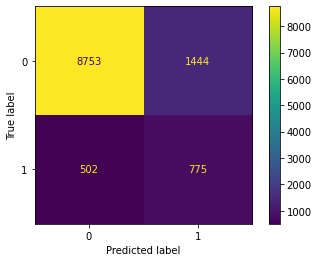

In [28]:
import time 
start = time.time()

# Importing DecisionTree module from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Creating Decision Trees for all depths and selecting one with max Recall
acc_list = []
rec_list = []
prec_list = []
for i in range(1,n_cols+1):
	tree_clf = DecisionTreeClassifier(max_depth=i, 
									min_samples_leaf=5,
									random_state=37,
									class_weight="balanced")
	tree_clf.fit(x_train,y_train)
	y_test_pred = tree_clf.predict(x_test)
	acc_list.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
	rec_list.append(sklearn.metrics.recall_score(y_test, y_test_pred))
	prec_list.append(sklearn.metrics.precision_score(y_test, y_test_pred))

rec_thresh = 0.6
prec_list_red = []
for i in range(len(prec_list)):
	if rec_list[i] >= rec_thresh:
		prec_list_red.append(prec_list[i])

max_rec_ind = prec_list.index(max(prec_list_red))
depth_max_rec = max_rec_ind+1

final_tree_clf = DecisionTreeClassifier(max_depth=depth_max_rec, 
										min_samples_leaf=5,
										random_state=37,
										class_weight="balanced")
final_tree_clf.fit(x_train,y_train)
y_test_pred = final_tree_clf.predict(x_test)

print("Depth for Max Recall: ", depth_max_rec)
print("Accuracy for Decision Tree: ", np.round(sklearn.metrics.accuracy_score(y_test, y_test_pred)*100,2), '%')
print("Precision for Decision Tree: ", np.round(sklearn.metrics.precision_score(y_test, y_test_pred)*100,2), '%')
print("Recall for Decision Tree: ", np.round(sklearn.metrics.recall_score(y_test, y_test_pred)*100,2), '%')
print("F1 score for Decision Tree:", np.round(sklearn.metrics.f1_score(y_test, y_test_pred)*100,2), "\n")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=final_tree_clf.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_tree_clf.classes_)
disp.plot()
plt.show

end = time.time()

print("Time taken by decision tree:",(end-start),"seconds")

### Naïve Bayes Classifier (Using Smote)

Counter({0: 16652, 1: 8326})
Accuracy percentage for Naive Bayes : 82.32 %
Precision percentage for Naive Bayes: 32.69 %
Recall percentage for Naive Bayes: 55.6 %
F1 score for Naive Bayes: 41.17 

Time taken by Naive Bayes Classifier : 0.3790857791900635 seconds


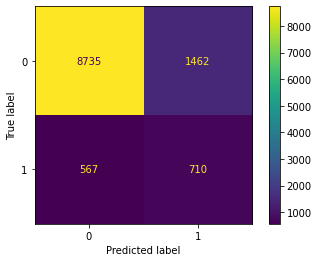

In [29]:
import time 
start = time.time()
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB



# Oversampling
oversample = SMOTE()
np.random.seed(37)

# Initializing the SMOTE function. We set our SMOTE function to oversample the minority to the number equal to the majority class. 
# Then, we take 35% of the oversampled minority class (randomly sampled).
oversample = SMOTE(sampling_strategy=0.35)

# We shall keep undersampled majority class 50% more than the oversampled minority class. 
# This is being done on order to resemble the composition of original dataframe in the SMOTE's dataframe
undersample = RandomUnderSampler(sampling_strategy=0.5)

# First we do oversampling for minority class and then undersampling for majority class
steps = [('o',oversample),('u',undersample)] 

# Creating the pipeline instance
pipeline = Pipeline(steps=steps) 

# Fitting the pipeline to our dataset
x_smote, y_smote = pipeline.fit_resample(x_train,y_train) 
Counter= Counter(y_smote)
print(Counter)
# Initialise and fit Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(x_smote, y_smote)

y_pred = gnb.predict(x_test)

# Evaluation metric and confusion matrix for naive bayes 

print("Accuracy percentage for Naive Bayes :", np.round(sklearn.metrics.accuracy_score(y_test, y_pred)*100,2), '%')
print("Precision percentage for Naive Bayes:", np.round(sklearn.metrics.precision_score(y_test, y_pred)*100,2), '%')
print("Recall percentage for Naive Bayes:", np.round(sklearn.metrics.recall_score(y_test, y_pred)*100,2), '%')
print("F1 score for Naive Bayes:",np.round(sklearn.metrics.f1_score(y_test, y_pred)*100,2), "\n")
cm = sklearn.metrics.confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb.classes_)
disp.plot()
plt.show
end = time.time()

print("Time taken by Naive Bayes Classifier :",(end-start),"seconds")

### Random Forest Classifier

Depth for Max Recall:  9
Accuracy for Random Forest:  85.97 %
Precision for Random Forest:  41.16 %
Recall for Random Forest:  60.69 %
F1 score for Random Forest: 49.05 

Time taken by Random Forest: 14.146710634231567 seconds


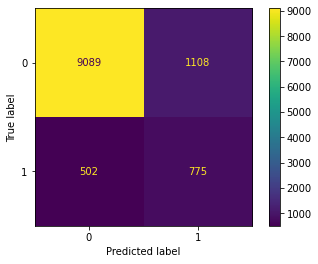

In [30]:
import time 
start = time.time()
# Importing RandomForest module from Skilearn
from sklearn.ensemble import RandomForestClassifier

# Creating Random Forests for all depths and selecting one with max Recall
acc_list = []
rec_list = []
prec_list = []
for i in range(1,x_ncol+1):
	rnd_for_clf = RandomForestClassifier(n_estimators=100, random_state=37, 
										max_depth=i,
										min_samples_leaf=5, 
										bootstrap=True, 
										oob_score=True, n_jobs=-1,
										class_weight="balanced")
	rnd_for_clf.fit(x_train,y_train)
	y_test_pred = rnd_for_clf.predict(x_test)
	acc_list.append(sklearn.metrics.accuracy_score(y_test, y_test_pred))
	rec_list.append(sklearn.metrics.recall_score(y_test, y_test_pred))
	prec_list.append(sklearn.metrics.precision_score(y_test, y_test_pred))

rec_thresh = 0.6
prec_list_red = []
for i in range(len(prec_list)):
	if rec_list[i] >= rec_thresh:
		prec_list_red.append(prec_list[i])

max_rec_ind = prec_list.index(max(prec_list_red))
depth_max_rec = max_rec_ind+1

final_rnd_for_clf = RandomForestClassifier(n_estimators=100, random_state=37, 
										max_depth = depth_max_rec, 
										min_samples_leaf = 5, 
										bootstrap=True, 
										oob_score=True, n_jobs=-1,
										class_weight="balanced")
final_rnd_for_clf.fit(x_train,y_train)
y_test_pred = final_rnd_for_clf.predict(x_test)

print("Depth for Max Recall: ", depth_max_rec)
print("Accuracy for Random Forest: ", np.round(sklearn.metrics.accuracy_score(y_test, y_test_pred)*100,2), '%')
print("Precision for Random Forest: ", np.round(sklearn.metrics.precision_score(y_test, y_test_pred)*100,2), '%')
print("Recall for Random Forest: ", np.round(sklearn.metrics.recall_score(y_test, y_test_pred)*100,2), '%')
print("F1 score for Random Forest:", np.round(sklearn.metrics.f1_score(y_test, y_test_pred)*100,2), "\n")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred, labels=final_rnd_for_clf.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_rnd_for_clf.classes_)
disp.plot()
plt.show

end = time.time()

print("Time taken by Random Forest:",(end-start),"seconds")